# Handwritten digit classification with CNN (LeNet-5)

In [127]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data.dataloader as dataloader

In [128]:
# Directory to load/save datasets
data_dir = './datasets/'
if (not os.path.isdir(data_dir)):
    os.mkdir(data_dir)

# Directory for figures
fig_dir = './figures/'
if (not os.path.isdir(fig_dir)):
    os.mkdir(fig_dir)

# General parameters
batch_size = 64
n_epochs = 20
learning_rate = 1e-4

# Image information
n_channels = 1  # Black and white images
pixel_size = 32
n_classes = 10

# Device
device = torch.device('cuda' if torch.cuda.is_available()
                      else 'mps' if torch.backends.mps.is_available()
                      else 'cpu')

## Data preparation

In [129]:
# Composition of transforms for our dataset (PIL images)
# The last normalization step rescales using the mean and std of the data
data_mean = [0.1307]
data_std = [0.308]
transform = transforms.Compose(
    [transforms.Resize(pixel_size),  # Bilinear interpolation
     transforms.ToTensor(),  # Conversion to tensor (float conversion and 0-1 rescaling)
     transforms.Normalize(data_mean, data_std)]
)

In [130]:
# Loading MNIST dataset of handwritten digits
train_data = datasets.MNIST(data_dir,
                            train=True,
                            download=True,
                            transform=transform)
test_data = datasets.MNIST(data_dir,
                           train=False,
                           download=True,
                           transform=transform)

# Let us split the training set into train and validation sets
train_size = 0.9
n_samples_train = int(len(train_data)*train_size)
n_samples_val = len(train_data) - n_samples_train
train_data, val_data \
    = torch.utils.data.random_split(train_data,
                                    [n_samples_train, n_samples_val],
                                    generator=torch.Generator().manual_seed(42))

In [131]:
print(f'Number of training samples: {len(train_data)}')
print(f'Number of validation samples: {len(val_data)}')
print(f'Number of testing samples: {len(test_data)}')

Number of training samples: 54000
Number of validation samples: 6000
Number of testing samples: 10000


## LeNet-5 neural network

LeNet-5 was one of the earliest convolutional neural networks, dating back to 1998.

In [132]:
def output_size_from_conv_pool(n_in: Tuple[int, int], conv_pool):
    kernel_size = conv_pool.kernel_size
    stride = conv_pool.stride
    dilation = conv_pool.dilation
    padding = conv_pool.padding

    if isinstance(kernel_size, tuple):
        n_out_0 = int(np.floor(
            (n_in[0] + 2*padding[0] - dilation[0]*(kernel_size[0] - 1) - 1)/stride[0] + 1))
        n_out_1 = int(np.floor(
            (n_in[1] + 2*padding[1] - dilation[1]*(kernel_size[1] - 1) - 1)/stride[1] + 1))
    else:
        n_out_0 = int(np.floor(
            (n_in[0] + 2*padding - dilation*(kernel_size - 1) - 1)/stride + 1))
        n_out_1 = n_out_0

    return (n_out_0, n_out_1)


class LeNet(nn.Module):
    def __init__(self,
                 n_channels: int,
                 pixel_size: int,
                 n_classes: int,
                 device) -> None:
        super().__init__()

        # Device configuration
        self.device = device

        # General architectural information
        self.activation = nn.ReLU()

        n_hidden_1 = 6
        n_hidden_2 = 16
        n_hidden_fc_1 = 120
        n_hidden_fc_2 = 84

        conv_kernel_size = 5
        pool_kernel_size = 2

        # Max pooling layer
        self.pool = nn.MaxPool2d(pool_kernel_size)

        # Convolutional layers
        self.conv1 = nn.Conv2d(n_channels, n_hidden_1, conv_kernel_size)
        self.conv2 = nn.Conv2d(n_hidden_1, n_hidden_2, conv_kernel_size)
        
        # What pixel_size becomes through the initial layers
        # To set the input size of the first fully connected layer
        output_size = (pixel_size, pixel_size)
        output_size = output_size_from_conv_pool(output_size, self.conv1)
        output_size = output_size_from_conv_pool(output_size, self.pool)
        output_size = output_size_from_conv_pool(output_size, self.conv2)
        output_size = output_size_from_conv_pool(output_size, self.pool)
        output_size = output_size[0]
        
        if output_size <= 0:
            raise ValueError('output_size <= 0, check other dimensions to get output_size > 0')    
        
        n_outputs_from_conv = n_hidden_2*output_size**2
        
        # Fully connected layers
        self.linear1 = nn.Linear(n_outputs_from_conv, n_hidden_fc_1)
        self.linear2 = nn.Linear(n_hidden_fc_1, n_hidden_fc_2)
        self.linear3 = nn.Linear(n_hidden_fc_2, n_classes)

        # Initialize loggers
        self.train_loss_logger = []
        self.train_accuracy_logger = []
        self.val_accuracy_logger = []


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Let us assume our input x has shape 
        # (batch_size, n_channels=3, pixel_size=32, pixel_size=32)
        # and needs to be classified among n_classes=10 classes

        x = self.activation(self.conv1(x))      # (batch_size, 6, 28, 28)
        x = self.pool(x)                        # (batch_size, 6, 14, 14)
        x = self.activation(self.conv2(x))      # (batch_size, 16, 10, 10)
        x = self.pool(x)                        # (batch_size, 16, 5, 5)

        x = torch.flatten(x, 1)                 # (batch_size, 16*5*5=400)

        x = self.activation(self.linear1(x))    # (batch_size, 84)
        x = self.activation(self.linear2(x))    # (batch_size, 120)
        x = self.linear3(x)                     # (batch_size, n_classes=10)

        return x
    

    def set_data(self,
                 train_data,
                 val_data,
                 test_data,
                 batch_size) -> None:
        # Set data loaders
        self.train_loader = dataloader.DataLoader(train_data,
                                                  shuffle=True,
                                                  batch_size=batch_size)
        self.val_loader = dataloader.DataLoader(val_data,
                                                shuffle=False,
                                                batch_size=batch_size)
        self.test_loader = dataloader.DataLoader(test_data,
                                                 shuffle=False,
                                                 batch_size=batch_size)
    

    def set_optimizer(self, learning_rate, loss_function):
        # Set optimizer parameters
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.loss_function = loss_function


    def train_model(self) -> None:
        self.train(True)

        for _, (x, y) in enumerate(tqdm(self.train_loader, leave=False, desc='Training')):
            fx = self.forward(x.to(self.device))
            loss = self.loss_function(fx, y.to(self.device))

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            self.train_loss_logger.append(loss.item())


    def evaluate_accuracy(self, which_data: str) -> float:
        self.train(False)

        # Choose data loader
        if which_data.lower() == 'train':
            loader = self.train_loader
        elif which_data.lower() == 'val':
            loader = self.val_loader
        elif which_data.lower() == 'test':
            loader = self.test_loader
        else:
            raise ValueError('which_data should be train, val or test')

        # Compute accuracy
        accuracy = 0.
        with torch.no_grad():
            for _, (x, y) in enumerate(tqdm(loader, leave=False, desc='Evaluating')):
                fx = self.forward(x.to(self.device))
                matches = (fx.argmax(1) == y.to(self.device))
                accuracy += matches.sum().item()
        accuracy = accuracy/len(loader.dataset)

        # Update loggers if relevant
        if which_data.lower() == 'train':
            self.train_accuracy_logger.append(accuracy)
        elif which_data.lower() == 'val':
            self.val_accuracy_logger.append(accuracy)

        return accuracy        

In [133]:
# Set up model, data and optimizer
model = LeNet(n_channels=n_channels,
              pixel_size=pixel_size,
              n_classes=n_classes,
              device=device).to(device)

model.set_data(train_data=train_data,
               val_data=val_data,
               test_data=test_data,
               batch_size=batch_size)

model.set_optimizer(learning_rate=learning_rate,
                    loss_function=nn.CrossEntropyLoss())

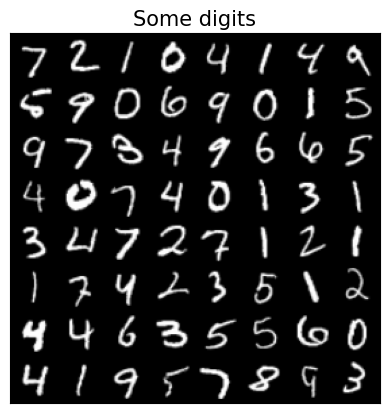

In [134]:
# Let us visualize a batch of images
data_iter = iter(model.test_loader)
images, labels = next(data_iter)

out = torchvision.utils.make_grid(images, 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.tick_params(axis='both',
                which='both',
                left=False,
                labelleft=False,
                bottom=False,
                labelbottom=False)
plt.title('Some digits', fontsize=15)
plt.savefig(os.path.join(fig_dir, '1_some_digits.png'),
            bbox_inches='tight', dpi=600)
plt.show()

## Training

In [ ]:
for epoch in trange(n_epochs, leave=False, desc='Epoch'):
    # Train
    model.train_model()
    
    # Evaluate and log accuracy on training and validation sets
    _ = model.evaluate_accuracy(which_data='train')
    _ = model.evaluate_accuracy(which_data='val')

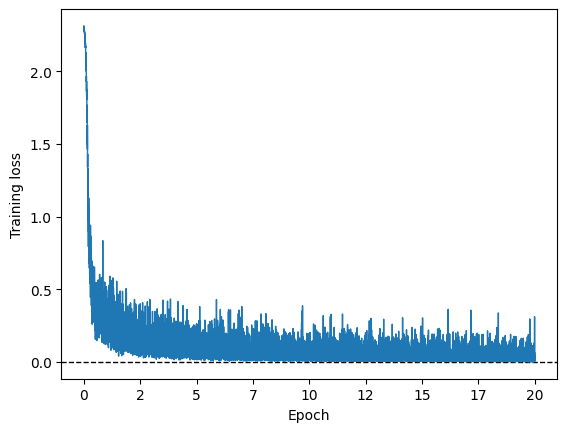

In [136]:
x_epoch = np.linspace(0, n_epochs, len(model.train_loss_logger))
plt.axhline(y=0, ls='--', color='k', lw=1)
plt.plot(x_epoch, model.train_loss_logger, lw=1)

xticks_format = plt.FuncFormatter(lambda y, pos: f'{int(y)}')
plt.gca().xaxis.set_major_formatter(xticks_format)
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.savefig(os.path.join(fig_dir, '2_training_loss.png'),
            bbox_inches='tight', dpi=600)
plt.show()

The training loss is rather noisy, as one would expect when using mini-batch gradient descent.

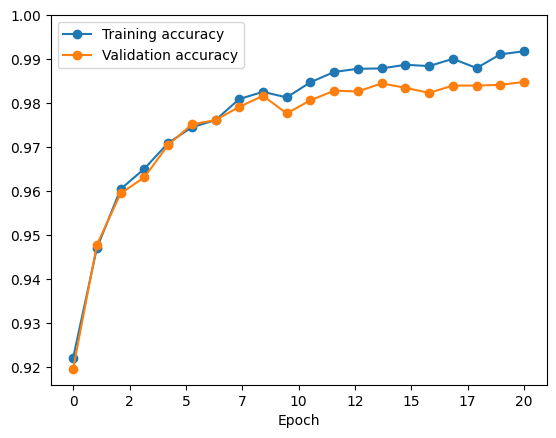

In [137]:
x_epoch = np.linspace(0, n_epochs, len(model.train_accuracy_logger))
plt.plot(x_epoch, model.train_accuracy_logger, marker='o', label='Training accuracy')

x_epoch = np.linspace(0, n_epochs, len(model.val_accuracy_logger))
plt.plot(x_epoch, model.val_accuracy_logger, marker='o', label='Validation accuracy')

plt.ylim(top=1)
xticks_format = plt.FuncFormatter(lambda y, pos: f'{int(y)}')
plt.gca().xaxis.set_major_formatter(xticks_format)
plt.xlabel('Epoch')
plt.legend()
plt.savefig(os.path.join(fig_dir, '3_training_validation_accuracy.png'),
            bbox_inches='tight', dpi=600)
plt.show()

The training accuracy slightly overshoots the validation accuracy, which may indicate some overfitting (assuming the training and validation sets share the exact same distribution).

## Evaluation

### Accuracy

In [138]:
testing_accuracy = model.evaluate_accuracy(which_data='test')

print(f'Accuracy on the testing set: {100*testing_accuracy:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on the testing set: 98.82%


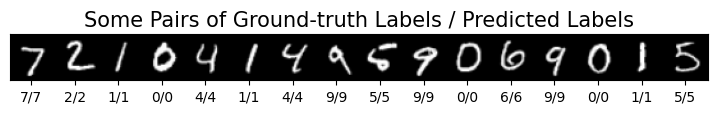

In [152]:
# Visualization of a few predictions
n_images = 16

with torch.no_grad():
    fx = model(images[:n_images].to(device))
    predictions = fx.argmax(1)

plt.figure(figsize=(9, 5))
out = torchvision.utils.make_grid(images[:n_images], n_images, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

ground_truth_labels = list([int(x) for x in labels[:n_images].cpu().numpy()])
predicted_labels = list([int(x) for x in predictions.cpu().numpy()])

xticks = pixel_size*np.linspace(0, n_images, n_images) + pixel_size/2
xtick_labels = [f'{ground_truth_labels[i]}/{predicted_labels[i]}' for i in range(n_images)]
plt.xticks(ticks=xticks, labels=xtick_labels)
plt.yticks([])
plt.title('Some Pairs of Ground-truth Labels / Predicted Labels', fontsize=15)
plt.savefig(os.path.join(fig_dir, '4_label_predictions.png'),
            bbox_inches='tight', dpi=600)
plt.show()

### Feature maps

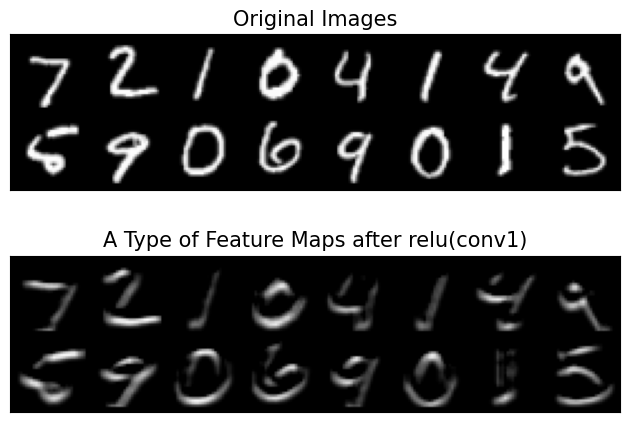

In [144]:
# Visualizations of a feature after relu(conv1)
n_images = 16
idx_feature = 3

with torch.no_grad():
    model_out = F.relu(model.conv1(images.to(device)))
feature_maps = model_out[:n_images, idx_feature].unsqueeze(1).detach().cpu()

_, ax = plt.subplots(2, 1)

out = torchvision.utils.make_grid(images[:n_images], n_images//2, normalize=True)
ax[0].imshow(out.numpy().transpose((1, 2, 0)))
ax[0].tick_params(axis='both',
                  which='both',
                  left=False,
                  labelleft=False,
                  bottom=False,
                  labelbottom=False)
ax[0].set_title('Original Images', fontsize=15)

out = torchvision.utils.make_grid(feature_maps, n_images//2, normalize=True)
ax[1].imshow(out.numpy().transpose((1, 2, 0)))
ax[1].tick_params(axis='both',
                  which='both',
                  left=False,
                  labelleft=False,
                  bottom=False,
                  labelbottom=False)
ax[1].set_title('A Type of Feature Maps after relu(conv1)', fontsize=15)
plt.tight_layout(h_pad=1)
plt.savefig(os.path.join(fig_dir, '5_feature_map_1.png'),
            bbox_inches='tight', dpi=600)
plt.show()

These feature maps seem to detect edges going (from bottom to top) from dark to bright.

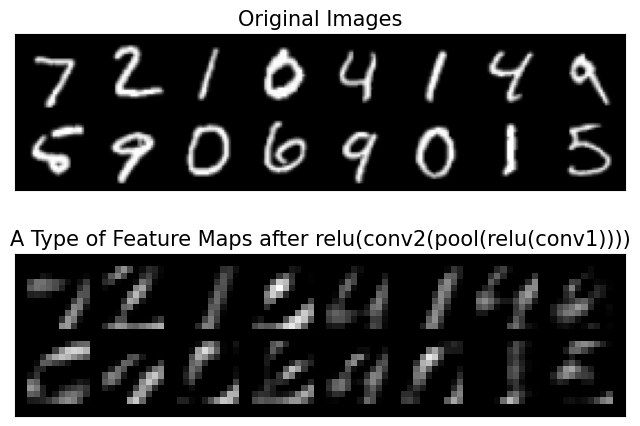

In [151]:
# Visualizations of a feature after relu(conv2(pool(relu(conv1))))
n_images = 16
idx_feature = 7

with torch.no_grad():
    model_out = F.relu(model.conv2(model.pool(F.relu(model.conv1(images.to(device))))))
feature_maps = model_out[:n_images, idx_feature].unsqueeze(1).detach().cpu()

_, ax = plt.subplots(2, 1)

out = torchvision.utils.make_grid(images[:n_images], n_images//2, normalize=True)
ax[0].imshow(out.numpy().transpose((1, 2, 0)))
ax[0].tick_params(axis='both',
                  which='both',
                  left=False,
                  labelleft=False,
                  bottom=False,
                  labelbottom=False)
ax[0].set_title('Original Images', fontsize=15)

out = torchvision.utils.make_grid(feature_maps, n_images//2, normalize=True)
ax[1].imshow(out.numpy().transpose((1, 2, 0)))
ax[1].tick_params(axis='both',
                  which='both',
                  left=False,
                  labelleft=False,
                  bottom=False,
                  labelbottom=False)
ax[1].set_title('A Type of Feature Maps after relu(conv2(pool(relu(conv1))))', fontsize=15)
plt.tight_layout(h_pad=1)
plt.savefig(os.path.join(fig_dir, '6_feature_map_2.png'),
            bbox_inches='tight', dpi=600)
plt.show()

These feature maps seem to detect diagonal lines from top-right to bottom-left.